In [111]:
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

In [112]:
set_model_results = {}
PATH_NAIVE = './output/1-dictionary-naive-search'
PATH_CMS = './output/2-count-min-sketch+bloom_freq'
for i in range(10):
    set_model_results[f"naive_{i}"] = pd.read_csv(f"{PATH_NAIVE}/dataset_{i}.csv", index_col=0)
    set_model_results[f"cms_{i}"] = pd.read_csv(f"{PATH_CMS}/dataset_{i}.csv", index_col=0)

In [113]:
dict_matches = {}
list_indexes = list(set_model_results['naive_0'].index.values)
for dataset_key, dataset in set_model_results.items():
    dict_matches[dataset_key] = dataset.loc[:,'matched_words']
pd_matches = pd.DataFrame(dict_matches, index=list_indexes)

pd_matches

,naive_0,cms_0,naive_1,cms_1,naive_2,cms_2,naive_3,cms_3,naive_4,cms_4,naive_5,cms_5,naive_6,cms_6,naive_7,cms_7,naive_8,cms_8,naive_9,cms_9
I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
an,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
and,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apple,appeal,appeal,appeal,appeal,appeal,appeal,"{'appell', 'appeal', 'appel'}","{'appel', 'appell', 'appeal'}",appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal
banana,"{'bangunan', 'lannan', 'bandanna', 'bananas'}","{'lannan', 'bangunan', 'bandanna', 'bananas'}","{'hannan', 'ananta', 'banana'}","{'hannan', 'ananta', 'banana'}","{'anna', 'banana'}","{'anna', 'banana'}","{'bannon', 'annan', 'bandanas', 'bafana'}","{'annan', 'bannon', 'bandanas', 'bafana'}","{'bannon', 'anna', 'banana'}","{'bannon', 'anna', 'banana'}","{'bana', 'bannon', 'brannan', 'anynana', 'bana...","{'bana', 'banana', 'bannon', 'brannan', 'anyna...","{'anna', 'banana'}","{'anna', 'banana'}","{'lannan', 'ananda'}","{'ananda', 'lannan'}","{'banana', 'anna', 'nana', 'bandana'}","{'nana', 'anna', 'banana', 'bandana'}","{'gannan', 'bandanna', 'qiannan', 'nana', 'anna'}","{'gannan', 'nana', 'qiannan', 'anna', 'bandanna'}"
don't,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
error,"{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'rnrhof', 'rirwof', 'errors'}",error,error,error,error,error,error,error,error,"{'error', 'terror', 'errors', 'perron'}","{'error', 'perron', 'terror', 'errors'}","{'error', 'terror', 'perro', 'errors'}","{'error', 'perro', 'terror', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'terror', 'errors'}","{'error', 'terror', 'errors'}","{'error', 'errors'}","{'error', 'errors'}"
have,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hope,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
pd_matches = pd_matches.loc[pd_matches[pd_matches != 'NaN'].any(axis=1)]

In [115]:
pd_matches

,naive_0,cms_0,naive_1,cms_1,naive_2,cms_2,naive_3,cms_3,naive_4,cms_4,naive_5,cms_5,naive_6,cms_6,naive_7,cms_7,naive_8,cms_8,naive_9,cms_9
apple,appeal,appeal,appeal,appeal,appeal,appeal,"{'appell', 'appeal', 'appel'}","{'appel', 'appell', 'appeal'}",appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal,appeal
banana,"{'bangunan', 'lannan', 'bandanna', 'bananas'}","{'lannan', 'bangunan', 'bandanna', 'bananas'}","{'hannan', 'ananta', 'banana'}","{'hannan', 'ananta', 'banana'}","{'anna', 'banana'}","{'anna', 'banana'}","{'bannon', 'annan', 'bandanas', 'bafana'}","{'annan', 'bannon', 'bandanas', 'bafana'}","{'bannon', 'anna', 'banana'}","{'bannon', 'anna', 'banana'}","{'bana', 'bannon', 'brannan', 'anynana', 'bana...","{'bana', 'banana', 'bannon', 'brannan', 'anyna...","{'anna', 'banana'}","{'anna', 'banana'}","{'lannan', 'ananda'}","{'ananda', 'lannan'}","{'banana', 'anna', 'nana', 'bandana'}","{'nana', 'anna', 'banana', 'bandana'}","{'gannan', 'bandanna', 'qiannan', 'nana', 'anna'}","{'gannan', 'nana', 'qiannan', 'anna', 'bandanna'}"
error,"{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'rnrhof', 'rirwof', 'errors'}",error,error,error,error,error,error,error,error,"{'error', 'terror', 'errors', 'perron'}","{'error', 'perron', 'terror', 'errors'}","{'error', 'terror', 'perro', 'errors'}","{'error', 'perro', 'terror', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'terror', 'errors'}","{'error', 'terror', 'errors'}","{'error', 'errors'}","{'error', 'errors'}"
lemon,lemon,lemon,"{'leone', 'leon', 'lemmon', 'lemon'}","{'lemmon', 'leon', 'lemon', 'leone'}","{'leone', 'lemon'}","{'lemon', 'leone'}","{'leone', 'lemond'}","{'lemond', 'leone'}",lemon,lemon,"{'lemond', 'leon', 'lone', 'lemmon'}","{'lemmon', 'lemond', 'leon', 'lone'}",leone,leone,"{'leone', 'lone', 'lemmon', 'lemon'}","{'lemmon', 'lone', 'lemon', 'leone'}","{'leone', 'leon', 'lone'}","{'leon', 'lone', 'leone'}",leone,leone
pear,paper,paper,"{'pater', 'paper', 'pager'}","{'paper', 'pater', 'pager'}",paper,paper,paper,paper,paper,paper,paper,paper,paper,paper,"{'pajer', 'paper'}","{'paper', 'pajer'}",paper,paper,paper,paper
please,please,please,"{'please', 'leases'}","{'please', 'leases'}",please,please,please,please,"{'please', 'pleasures'}","{'please', 'pleasures'}",please,please,"{'please', 'pleased', 'pleasures'}","{'please', 'pleased', 'pleasures'}",please,please,please,please,please,please
possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible
wanna,NaN,NaN,NaN,NaN,"{'wanna', 'anna'}",NaN,"{'wanna', 'anna'}",NaN,anna,anna,anna,anna,anna,anna,"{'wanna', 'anna'}",NaN,"{'wannabe', 'anna'}","{'wannabe', 'anna'}","{'anna', 'hanna', 'ann'}","{'hanna', 'ann', 'anna'}"
watermelon,waterloo,waterloo,"{'waterloo', 'warren'}","{'waterloo', 'warren'}","{'weathermen', 'warren'}","{'warren', 'weathermen'}",warren,warren,"{'watermelon', 'wartime', 'warren'}","{'warren', 'watermelon', 'wartime'}","{'waterloo', 'waterman'}","{'waterloo', 'waterman'}","{'waterman', 'warren'}","{'waterman', 'warren'}",warren,warren,"{'waterloo', 'warren'}","{'waterloo', 'warren'}","{'wartel', 'warren'}","{'wartel', 'warren'}"


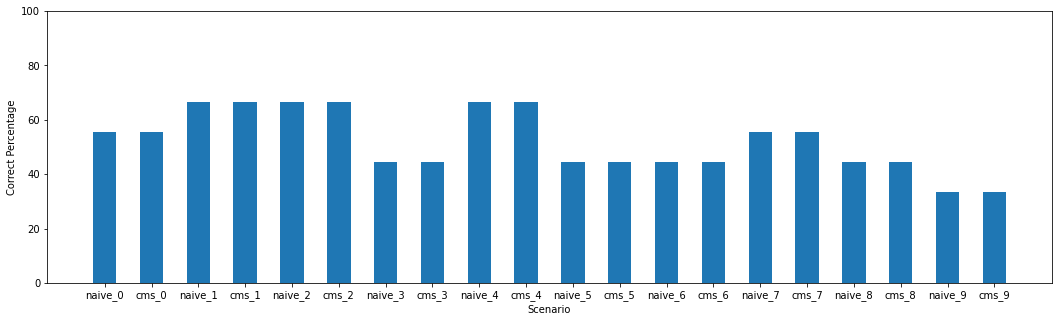

In [116]:
diff_series = {}
original_words = list(pd_matches.index.values)
diff_matches_all = []
for series_name, series in pd_matches.items():
  #print(list(series.index))
  diff_matches = [{word:series[word]} for word in list(series.index)]
  diff_matches_all.append(diff_matches)
  diff_matches = [{word:series[word]} for word in list(series.index) if 
       (type(series[word]) == str and not series[word].startswith('{') and word != series[word]) or
       (type(series[word]) == str and series[word].startswith('{') and word not in [re.sub(r'\W+', '', subword) for subword in series[word].split(",")])]
  diff_series[series_name] = 100 * (1 - (len(diff_matches) / len(series.values)))
diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(18, 5))  # width:20, height:3
plt.bar(diff_series.keys(), diff_series.values(), align='center', width=0.5)
plt.xlabel('Scenario')
plt.ylabel('Correct Percentage')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.show()

In [132]:
dict_diffes = {}
for word in original_words:
    dict_diffes[word] = []

for diff_match in diff_matches_all:
    for diff in diff_match:
        diff_match_key = list(diff.keys())[0]
        diff_match_value = list(diff.values())[0]
        if type(diff_match_value) != str:
            dict_diffes[diff_match_key] = []
        elif not diff_match_value.startswith('{'):
            dict_diffes[diff_match_key].append(diff_match_value)
        else:
            diff_match_values = [re.sub(r'\W+', '', subword) for subword in diff_match_value.split(",")]
            dict_diffes[diff_match_key].extend(diff_match_values)
            
# Unique parameters
dict_diffes = {k: set(v) for k, v in dict_diffes.items()}
dict_diffes
dict_diffes_max_len = max(len(v) for k, v in dict_diffes.items())
dict_diffes_new = {k: ['---' for i in range(dict_diffes_max_len)] for k, v in dict_diffes.items()}
for k, v in dict_diffes_new.items():
  for idx, item in enumerate(dict_diffes[k]):
      dict_diffes_new[k][idx] = item
dict_diffes_new

dict_diffes_df = pd.DataFrame(dict_diffes_new)
dict_diffes_df

,apple,banana,error,lemon,pear,please,possible,wanna,watermelon
0,appell,bandanna,perro,lemmon,pater,pleased,possible,hanna,waterman
1,appeal,anynana,rnrhof,leon,paper,leases,---,ann,watermelon
2,appel,qiannan,errol,lemond,pajer,please,---,wannabe,waterloo
3,---,bandana,error,leone,pager,pleasures,---,anna,warren
4,---,bangunan,terror,lone,---,---,---,---,wartel
5,---,bafana,errors,lemon,---,---,---,---,weathermen
6,---,bananas,perron,---,---,---,---,---,wartime
7,---,annan,rirwof,---,---,---,---,---,---
8,---,banana,---,---,---,---,---,---,---
9,---,ananda,---,---,---,---,---,---,---


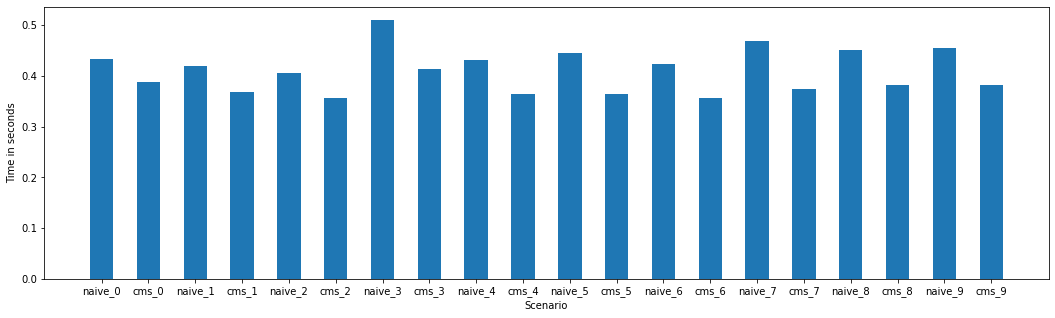

In [148]:
dict_times = {}
list_indexes = list(set_model_results['naive_0'].index.values)
for dataset_key, dataset in set_model_results.items():
    dict_times[dataset_key] = dataset.iloc[0]['time_sec']
pd_times = pd.DataFrame(dict_times, index=[0])

plt.figure(figsize=(18, 5))  # width:20, height:3
plt.bar(pd_times.columns, pd_times.iloc[0], align='center', width=0.5)
plt.xlabel('Scenario')
plt.ylabel('Time in seconds')
ax = plt.gca()
plt.show()